# Predicting the number of pit stops

The number of pit stops and their duration have decreased with the years? In the first phase of this subproject I'll try to predict how many stops will there be in the race and later I would like to predict when would them happen.

Bur first, some EDA...

In [1]:
from IPython.display import Image 
from IPython.core.display import HTML 
Image(url= "https://media.giphy.com/media/MovqJSMROh1gA/giphy.gif") 

## EDA

### Setting up the main dataset

In [2]:
#The data stored in this path is obtained from the API of https://ergast.com/mrd/. It is continuously updated.
#To update this data please run the file "API_Requests_Results_Qualifying_Laps_PitStops.py"

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import make_scorer #set scores desired to train models
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score #measures used to evaluate the models


path = 'C:/Users/gabri/Dropbox/Gaby/Proyectos/My_Portafolio/F1/Data/'

PitsDF=pd.read_csv(path+"PitsDF.csv")

selectednumber=19440102 #randomseed

We should import info from the results data so that we can know the result of each driver at the end of each race. We should only take into account the drivers that ended each race. If the driver do not ends the race, they will probably have no pit stops.

In [3]:
ResultsDF=pd.read_csv(path+"ResultsDF.csv")
PitsDF=PitsDF.drop(columns=['Unnamed: 0'])

In [4]:
#Transforming pits duration into seconds:
PitsDF[['durationSEC','nothing']]=PitsDF['duration'].str.split(":", expand=True)
PitsDF['duration_in_sec']=PitsDF['durationSEC'].astype(float)
PitsDF=PitsDF.drop(columns=['durationSEC','nothing'])


In [5]:
#Creating Season-Round feature:
ResultsDF["Season-Round-Driver"]=ResultsDF["season"].astype(str)+"-"+ResultsDF["round"].astype(str)+"-"+ResultsDF["Driver.driverId"].astype(str)
PitsDF["Season-Round-Driver"]=PitsDF["season"].astype(str)+"-"+PitsDF["round"].astype(str)+"-"+PitsDF["driverId"].astype(str)

In [6]:
#Left Join of the Pits DF with the Results DF
PitsExtraDF=PitsDF.merge(ResultsDF[["Season-Round-Driver","status",'Constructor.constructorId','Constructor.name',"laps"]],on="Season-Round-Driver",how="left")

In [7]:
#Top number of pits per race:
PitsExtraDF["stop"].unique()

array([1, 2, 3, 4], dtype=int64)

In [8]:
#Dividing the main df into separate ones taking into account the number of stops, to then unify them:
Pits1ExtraDF = PitsExtraDF[PitsExtraDF["stop"]==1].rename(columns={'lap': 'Pit1_lap',"time":"Pit1_time","duration_in_sec":"Pit1_duration"})
Pits2ExtraDF = PitsExtraDF[PitsExtraDF["stop"]==2].rename(columns={'lap': 'Pit2_lap',"time":"Pit2_time","duration_in_sec":"Pit2_duration"})
Pits3ExtraDF = PitsExtraDF[PitsExtraDF["stop"]==3].rename(columns={'lap': 'Pit3_lap',"time":"Pit3_time","duration_in_sec":"Pit3_duration"})
Pits4ExtraDF = PitsExtraDF[PitsExtraDF["stop"]==4].rename(columns={'lap': 'Pit4_lap',"time":"Pit4_time","duration_in_sec":"Pit4_duration"})

PitsUnified=Pits1ExtraDF[['Season-Round-Driver', 'date', 'status', 'driverId', 'season','round', 'raceName', 'Circuit.circuitId', 'Circuit.circuitName',
       'Circuit.Location.country','Constructor.constructorId', 'Constructor.name', 'laps',
       'Pit1_lap', 'Pit1_time', 'Pit1_duration']]

#Unifying the separate datasets forming one dataset with one row per race and per driver
PitsUnified=PitsUnified.merge(Pits2ExtraDF[["Season-Round-Driver",'Pit2_lap', 'Pit2_time', 'Pit2_duration']],on="Season-Round-Driver",how="left")
PitsUnified=PitsUnified.merge(Pits3ExtraDF[["Season-Round-Driver",'Pit3_lap', 'Pit3_time', 'Pit3_duration']],on="Season-Round-Driver",how="left")
PitsUnified=PitsUnified.merge(Pits4ExtraDF[["Season-Round-Driver",'Pit4_lap', 'Pit4_time', 'Pit4_duration']],on="Season-Round-Driver",how="left")

#Replacing na values of pits columns with 0
PitsUnified=PitsUnified.fillna(0)

len(PitsUnified) #counting the number of rows

3900

In [9]:
#Adding the total number of pits per driver and per race
conditions = [
    (PitsUnified['Pit4_lap'] > 0),
    (PitsUnified['Pit4_lap'] == 0) & (PitsUnified['Pit3_lap'] > 0),
    (PitsUnified['Pit4_lap'] == 0) & (PitsUnified['Pit3_lap'] == 0) & (PitsUnified['Pit2_lap'] > 0),
    (PitsUnified['Pit4_lap'] == 0) & (PitsUnified['Pit3_lap'] == 0) & (PitsUnified['Pit2_lap'] == 0) & (PitsUnified['Pit1_lap'] > 0)
]

values = [4, 3, 2, 1]

PitsUnified['Num_Pits'] = np.select(conditions, values)

In [10]:
#Creating the feature of laps per pitstop. This tells us how many laps in average you can do between pit stops
PitsUnified["LapsbetweenPitstops"]=PitsUnified["laps"]/PitsUnified['Num_Pits']

#Pits of drivers that ended the races:
PitsUnified_Finished=PitsUnified[PitsUnified["status"]=="Finished"].reset_index()

#Dropping unnecesary columns>
PitsUnified_Finished=PitsUnified_Finished.drop(columns=["index"])

#Now we have one row per race and driver, only of the drivers who finished the race
PitsUnified_Finished.tail(5)


,Season-Round-Driver,date,status,driverId,season,round,raceName,Circuit.circuitId,Circuit.circuitName,Circuit.Location.country,...,Pit2_time,Pit2_duration,Pit3_lap,Pit3_time,Pit3_duration,Pit4_lap,Pit4_time,Pit4_duration,Num_Pits,LapsbetweenPitstops
2060,2022-2-kevin_magnussen,2022-03-27,Finished,kevin_magnussen,2022,2,Saudi Arabian Grand Prix,jeddah,Jeddah Corniche Circuit,Saudi Arabia,...,0,0.0,0.0,0,0.0,0.0,0,0.0,1,50.0
2061,2022-2-hulkenberg,2022-03-27,Finished,hulkenberg,2022,2,Saudi Arabian Grand Prix,jeddah,Jeddah Corniche Circuit,Saudi Arabia,...,0,0.0,0.0,0,0.0,0.0,0,0.0,1,50.0
2062,2022-2-hulkenberg,2022-03-27,Finished,hulkenberg,2022,2,Saudi Arabian Grand Prix,jeddah,Jeddah Corniche Circuit,Saudi Arabia,...,0,0.0,0.0,0,0.0,0.0,0,0.0,1,50.0
2063,2022-2-hamilton,2022-03-27,Finished,hamilton,2022,2,Saudi Arabian Grand Prix,jeddah,Jeddah Corniche Circuit,Saudi Arabia,...,0,0.0,0.0,0,0.0,0.0,0,0.0,1,50.0
2064,2022-2-hamilton,2022-03-27,Finished,hamilton,2022,2,Saudi Arabian Grand Prix,jeddah,Jeddah Corniche Circuit,Saudi Arabia,...,0,0.0,0.0,0,0.0,0.0,0,0.0,1,50.0


### Average number of pit stops per circuit

Mugello circuit and Park Zandvoort are on average the circuits that have the highest number of pit stops per race

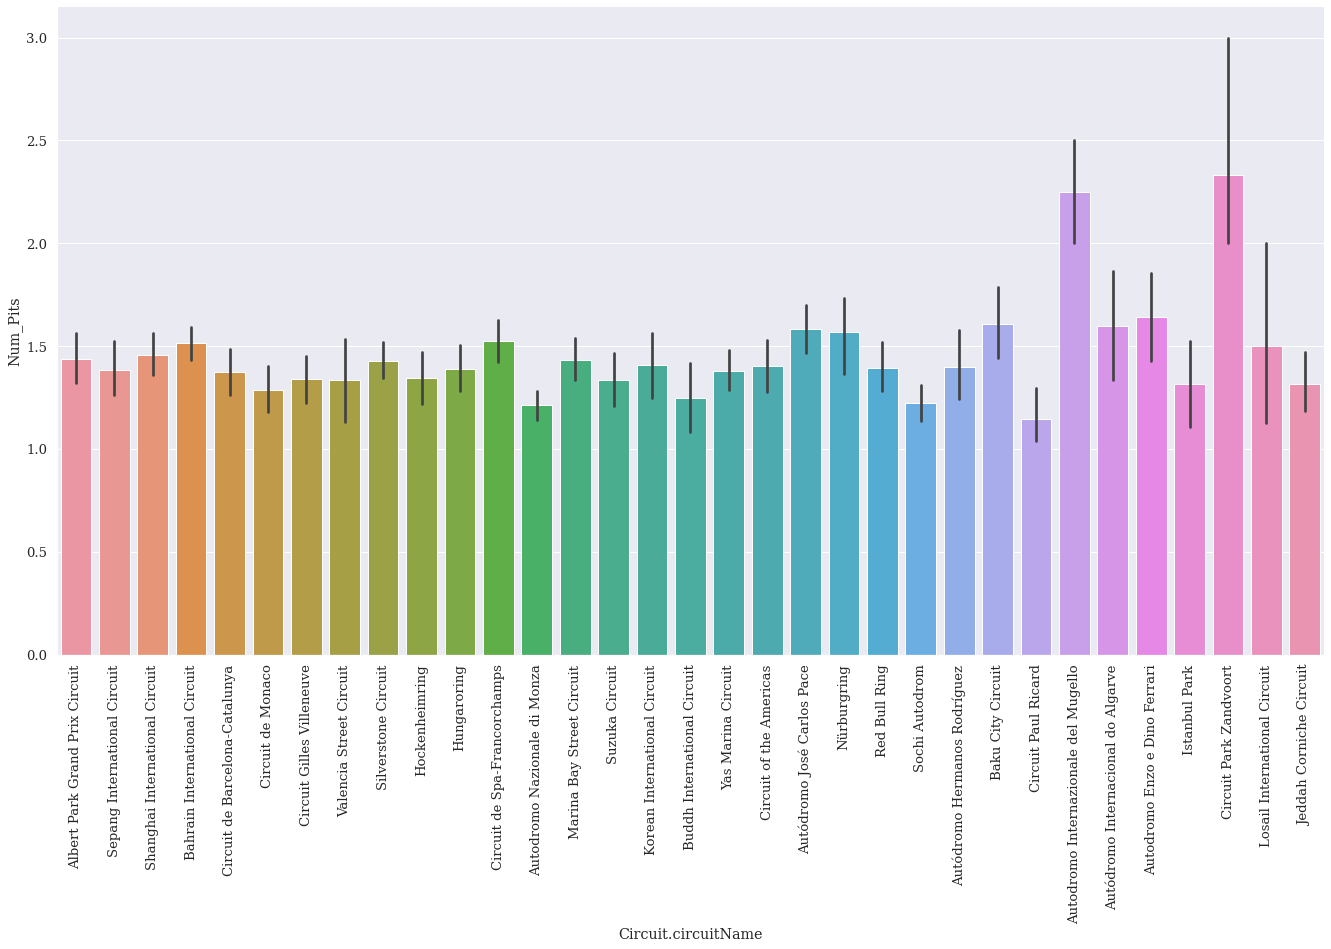

In [11]:
sns.set_theme(style="darkgrid", palette="magma",font_scale=1.2,font="serif")
sns.catplot(data=PitsUnified_Finished,x="Circuit.circuitName", y="Num_Pits",kind="bar",height=10,aspect=2)
plt.xticks(rotation=90)
plt.show()

### Average numper of pit stops per year

The number of pit stops on average decreased in 2018. This might have been caused by several causes like changes in the regulations, different circuits in that season, etc.

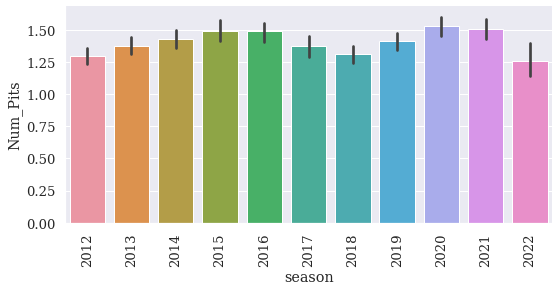

In [12]:
sns.set_theme(style="darkgrid", palette="magma",font_scale=1.2,font="serif")
sns.catplot(data=PitsUnified_Finished,x="season", y="Num_Pits",kind="bar",height=4,aspect=2)
plt.xticks(rotation=90)
plt.show()

### Average number of laps between pit stops per circuit

We can see that contrary to what it was believed, the number of laps on average per pit stop have increased and decreased depending on each circuit.

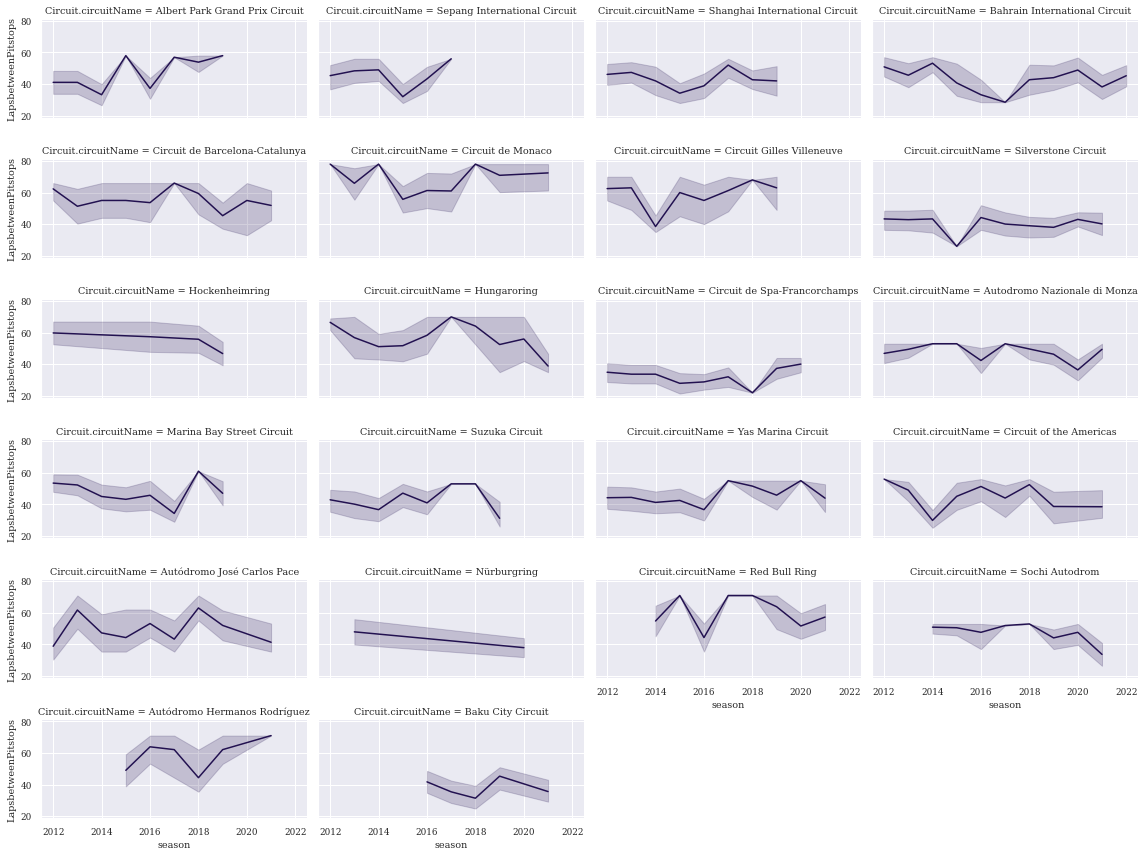

In [13]:
#Selecting specific circuits where at least two seasons a race has been helds=
SelectedCircuits=['albert_park', 'sepang', 'shanghai', 'bahrain', 'catalunya',
       'monaco', 'villeneuve', 'silverstone',
       'hockenheimring', 'hungaroring', 'spa', 'monza', 'marina_bay',
       'suzuka', 'yas_marina', 'americas',
       'interlagos', 'nurburgring', 'red_bull_ring', 'sochi', 'rodriguez',
       'BAK']

PitsUnified_Finished_Selected=PitsUnified_Finished[PitsUnified_Finished["Circuit.circuitId"].isin(SelectedCircuits) == True]

sns.set_theme(style="darkgrid", palette="magma",font_scale=0.8,font="serif")
sns.relplot(data=PitsUnified_Finished_Selected,x="season", y="LapsbetweenPitstops",col="Circuit.circuitName",col_wrap=4,kind="line",height=2,aspect=2)

### Average number of laps between pit stops

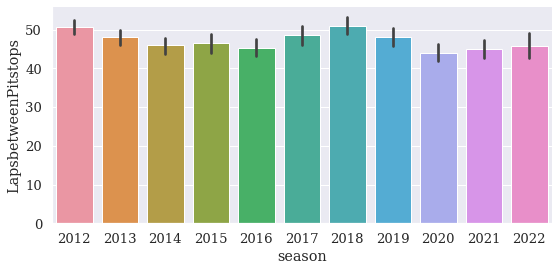

In [14]:
sns.set_theme(style="darkgrid", palette="magma",font_scale=1.2,font="serif")
sns.catplot(data=PitsUnified_Finished,x="season", y="LapsbetweenPitstops",kind="bar",height=4,aspect=2)

### Encoding the categorical features

In [15]:
from sklearn.preprocessing import LabelEncoder

#Features to encode:
to_encode=['Season-Round-Driver', 'driverId', 'Circuit.circuitId','Circuit.Location.country', 'Constructor.constructorId']

for n in to_encode:
    encoder = LabelEncoder()
    encoder.fit(PitsUnified_Finished[n])
    nameencoded=n+"_enc"
    encoders=encoder.transform(PitsUnified_Finished[n])
    PitsUnified_Finished[nameencoded]=encoders

PitsUnified_Finished=PitsUnified_Finished.reset_index() #reset index of added features, if this is not done, there is an error later
PitsUnified_Finished=PitsUnified_Finished.drop(columns=["index"])

### Relationship between features

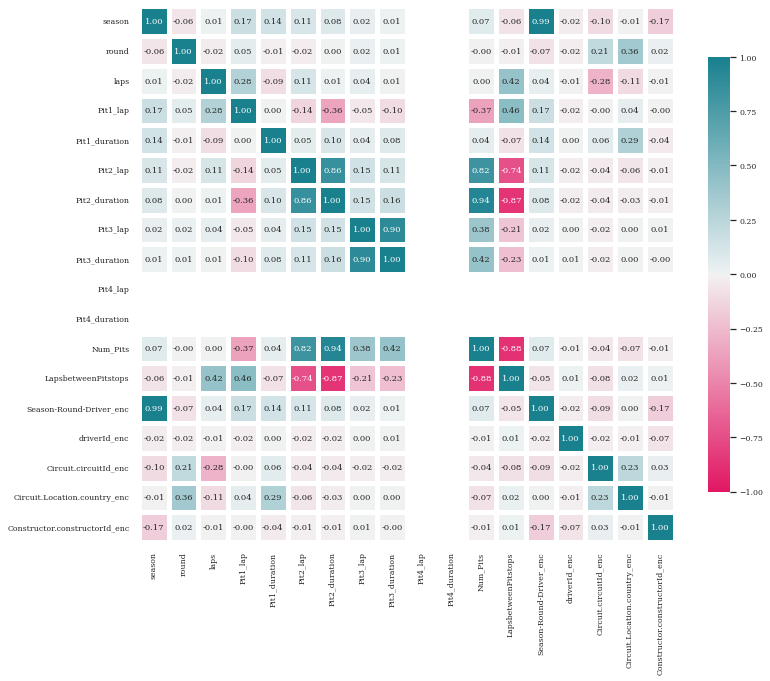

In [16]:
#Relationship between all the variables

#Calculating correlation: Heatmap
sns.set_theme(style="whitegrid", palette="magma",font_scale=0.7,font="serif")
fig, ax = plt.subplots(figsize=(12, 10))
cmap = sns.diverging_palette(0, 210, 95, 49, as_cmap=True)
sns.heatmap(PitsUnified_Finished.corr(), annot=True, fmt=".2f", 
           linewidths=5,cmap=cmap, vmin=-1, vmax=1, 
           cbar_kws={"shrink": .8}, square=True)
plt.show()

### Before making predictions...

In [17]:
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score #measures used to evaluate the models
from sklearn.metrics import confusion_matrix, classification_report #confusion matrix to evaluate results

from sklearn.model_selection import GridSearchCV #Hyperparameter optimization
from sklearn.model_selection import KFold #set kfold configuration
from sklearn.model_selection import cross_val_score #cross validation
from sklearn.metrics import make_scorer #set scores desired to train models
from sklearn.metrics import mean_squared_error

#Set scorers
f1_scorer=make_scorer(f1_score,average="weighted")
accuracy_scorer=make_scorer(accuracy_score)

### Function to test and evaluate the algorithms
def testing_the_classifier(ticks_, thesize=(5,3)):
    Train=pd.DataFrame()
    Train["Predicted"]=y_train_predicted
    Train["Real"]=y_train.tolist()

    Test=pd.DataFrame()
    Test["Predicted"]=y_test_predicted
    Test["Real"]=y_test.tolist()

    #Generate the confusion matrixes

    cf_matrixtrain = confusion_matrix(Train["Real"], Train["Predicted"])
    cf_matrixtest = confusion_matrix(Test["Real"], Test["Predicted"])

    print("\n Training Data:")
    sns.set_theme(style="whitegrid", palette="BuPu",font_scale=1,font="serif")
    plt.figure(figsize=thesize)
    ax = sns.heatmap(cf_matrixtrain, annot=True,cmap="BuPu",fmt='d')
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ')
    ax.xaxis.set_ticklabels(ticks_)
    ax.yaxis.set_ticklabels(ticks_)
    plt.show()

    print(classification_report(y_train, y_train_predicted))

    print("F1 Score:",f1_score(y_train, y_train_predicted,average="weighted"))
    print("Recall:",recall_score(y_train,y_train_predicted,average="weighted"))
    print("Precision:",precision_score(y_train,y_train_predicted,average="weighted"))

    

    print("\n Testing Data:")
    sns.set_theme(style="whitegrid", palette="BuPu",font_scale=1,font="serif")
    plt.figure(figsize=thesize)
    ax = sns.heatmap(cf_matrixtest, annot=True,cmap="BuPu",fmt='d')
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ')
    ax.xaxis.set_ticklabels(ticks_)
    ax.yaxis.set_ticklabels(ticks_)
    plt.show()

    print(classification_report(y_test, y_test_predicted))

    print("F1 Score:",f1_score(y_test, y_test_predicted,average="weighted"))
    print("Recall:",recall_score(y_test, y_test_predicted,average="weighted"))
    print("Precision:",precision_score(y_test, y_test_predicted,average="weighted"))


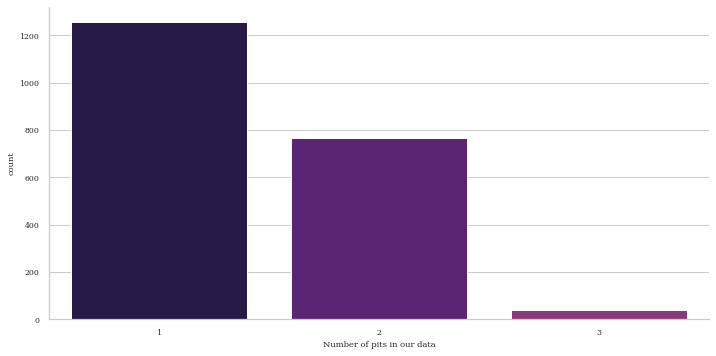

In [18]:
#Bar plot: class distribution
g=sns.catplot(x="Num_Pits",data=PitsUnified_Finished,kind="count",height=5,aspect=2)
g.set(xlabel="Number of pits in our data")
plt.show()

#There exists a class imbalance

In [19]:
len(PitsUnified_Finished[PitsUnified_Finished["Num_Pits"]==3]) #number of drivers-races with 3 pitstops

41

## 1st: Random Forest Classifier to predict the feature "Num_Pits"

In [20]:
#PitsUnified_Finished.columns

Selected=['season','round','laps', 'driverId_enc',
       'Circuit.circuitId_enc', 'Circuit.Location.country_enc',
       'Constructor.constructorId_enc']


In [21]:
#Divide data into training and testing - stratified
from sklearn.model_selection import train_test_split #separte train and test data

X_train, X_test, y_train, y_test = train_test_split(PitsUnified_Finished[Selected], PitsUnified_Finished["Num_Pits"], test_size=0.20,stratify=PitsUnified_Finished["Num_Pits"],random_state=selectednumber)


In [22]:
# from sklearn.ensemble import RandomForestClassifier

# #Cross Validation using Grid Search
# RF=RandomForestClassifier(random_state=selectednumber)
# tuned_parameters = {
#     #'bootstrap': [False,True], #it always shows a better result with bootstrapping in this case
#     'max_depth': [20,30,40],
#     'min_samples_leaf': [1,2], #in tests before only 1 and 2 were selected
#     'min_samples_split': [3,4,5],
#     'criterion': ["gini","entropy"],
#     "max_features":[None]} #None was always chosen

# for x in [5,7]:
#     clf1 = GridSearchCV(RF, tuned_parameters, cv=KFold(n_splits=x), scoring=f1_scorer)
#     clf1.fit(X_train, y_train)
#     print("Folds: ",x,"- F1 Scorer: ",clf1.best_score_," ",clf1.best_params_)

# for x in [5,7]:
#     clf2 = GridSearchCV(RF, tuned_parameters, cv=KFold(n_splits=x), scoring=accuracy_scorer)
#     clf2.fit(X_train, y_train)
#     print("Folds: ",x,"- Accuracy: ",clf2.best_score_," ",clf2.best_params_)

# Folds:  5 - F1 Scorer:  0.6224738621397922   {'criterion': 'gini', 'max_depth': 30, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 3}
# Folds:  7 - F1 Scorer:  0.6227720472041518   {'criterion': 'entropy', 'max_depth': 30, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 4}
# Folds:  5 - Accuracy:  0.6374182916781104   {'criterion': 'gini', 'max_depth': 20, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 5}
# Folds:  7 - Accuracy:  0.6398305084745762   {'criterion': 'entropy', 'max_depth': 20, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 5}

In [23]:
from sklearn.ensemble import RandomForestClassifier
RF1=RandomForestClassifier(random_state=selectednumber,n_estimators=100,max_depth=30,min_samples_split=4,criterion="gini",max_features=None,min_samples_leaf=1)
RF1.fit(X_train, y_train)
y_train_predicted=RF1.predict(X_train)
y_test_predicted=RF1.predict(X_test)

mse_train = mean_squared_error(y_train,y_train_predicted)
mse_test = mean_squared_error(y_test,y_test_predicted)
print(mse_train,"-",mse_test)

0.026634382566585957 - 0.423728813559322


## 1st: Results


 Training Data:


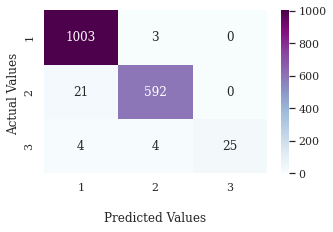

              precision    recall  f1-score   support

           1       0.98      1.00      0.99      1006
           2       0.99      0.97      0.98       613
           3       1.00      0.76      0.86        33

    accuracy                           0.98      1652
   macro avg       0.99      0.91      0.94      1652
weighted avg       0.98      0.98      0.98      1652

F1 Score: 0.9802893374409789
Recall: 0.9806295399515739
Precision: 0.9808543664922738

 Testing Data:


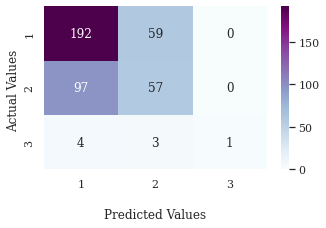

              precision    recall  f1-score   support

           1       0.66      0.76      0.71       251
           2       0.48      0.37      0.42       154
           3       1.00      0.12      0.22         8

    accuracy                           0.61       413
   macro avg       0.71      0.42      0.45       413
weighted avg       0.60      0.61      0.59       413

F1 Score: 0.5890119628903279
Recall: 0.6053268765133172
Precision: 0.5962288658160089


In [24]:
testing_the_classifier(["1","2","3"])

## 2nd: Random Forest Classifier to predict the feature Lap of pit stops (if any)

First, predicting the lap in which the first pit stop is done

Secondly, predicting the lap in which the second pit stop is done (0 is also an option with 0 pit stops)

Thirdly, predicting the lap in which the third pit stop is done (0 is also an option with 0 pit stops)

In [25]:
#Function to evaluate the models
from sklearn import metrics

def evaluatelapspitstops(y_train,y_train_predicted,y_test,y_test_predicted):
    y_true = y_train 
    y_pred = y_train_predicted 

    print("\n Training Scores:")
    print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_true, y_pred))
    print('Mean Squared Error (MSE):', metrics.mean_squared_error(y_true, y_pred))
    print('Explained Variance Score:', metrics.explained_variance_score(y_true, y_pred))
    print('Max Error:', metrics.max_error(y_true, y_pred))
    print('R^2:', metrics.r2_score(y_true, y_pred))

    print("F1 Score:",f1_score(y_true, y_pred,average="weighted"))
    print("Recall:",recall_score(y_true,y_pred,average="weighted"))
    print("Precision:",precision_score(y_true,y_pred,average="weighted"))

    y_true = y_test 
    y_pred = y_test_predicted 
    
    print("\n Testing Scores:")
    print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_true, y_pred))
    print('Mean Squared Error (MSE):', metrics.mean_squared_error(y_true, y_pred))
    print('Max Error:', metrics.max_error(y_true, y_pred))
    print('R^2:', metrics.r2_score(y_true, y_pred))

    print("F1 Score:",f1_score(y_true, y_pred,average="weighted"))
    print("Recall:",recall_score(y_true,y_pred,average="weighted"))
    print("Precision:",precision_score(y_true,y_pred,average="weighted"))


In [26]:
#PitsUnified_Finished.columns

Selected=['season','round','laps', 'driverId_enc',
       'Circuit.circuitId_enc', 'Circuit.Location.country_enc',
       'Constructor.constructorId_enc','Pit1_lap','Pit2_lap','Pit3_lap','Pit4_lap',"Num_Pits"]

#The 3 features including the Pit laps will be taken out later

#randomseed

In [27]:
#Divide data into training and testing - stratified
from sklearn.model_selection import train_test_split #separte train and test data

X_train, X_test, y_train, y_test = train_test_split(PitsUnified_Finished[Selected], PitsUnified_Finished['Pit1_lap'], test_size=0.20,stratify=PitsUnified_Finished["Num_Pits"],random_state=selectednumber)
#X_train, X_test, y_train, y_test = train_test_split(PitsUnified_Finished[Selected], PitsUnified_Finished['Pit1_lap'], test_size=0.20,random_state=selectednumber)


In [28]:
PitInfotrain=X_train[['Pit1_lap','Pit2_lap','Pit3_lap','Pit4_lap',"Num_Pits"]] #we needed them to have this info in the correct order for later
X_train=X_train.drop(columns=['Pit1_lap','Pit2_lap','Pit3_lap','Pit4_lap',"Num_Pits"]) #the 3 features are dropped from the training set

PitInfotest=X_test[['Pit1_lap','Pit2_lap','Pit3_lap','Pit4_lap',"Num_Pits"]] #we needed them to have this info in the correct order for later
X_test=X_test.drop(columns=['Pit1_lap','Pit2_lap','Pit3_lap','Pit4_lap',"Num_Pits"]) #the 3 features are dropped from the training set


#### Starting to predict the lap of pit stop 1...

In [29]:
# #Cross Validation using Grid Search

# RF=RandomForestClassifier(random_state=selectednumber)
# tuned_parameters = {
#     #'bootstrap': [False,True], #it always shows a better result with bootstrapping in this case
#     'max_depth': [10,20,30],
#     'min_samples_leaf': [1,2,3],
#     'min_samples_split': [2,3,4],
#     'criterion': ["gini","entropy"],
#     "max_features":["auto",None]}

# for x in [5,7]:
#     clf1 = GridSearchCV(RF, tuned_parameters, cv=KFold(n_splits=x), scoring=f1_scorer)
#     clf1.fit(X_train, y_train)
#     print("Folds: ",x,"- F1 Scorer: ",clf1.best_score_," ",clf1.best_params_)

# for x in [5,7]:
#     clf2 = GridSearchCV(RF, tuned_parameters, cv=KFold(n_splits=x), scoring=accuracy_scorer)
#     clf2.fit(X_train, y_train)
#     print("Folds: ",x,"- Accuracy: ",clf2.best_score_," ",clf2.best_params_)

# Folds:  5 - F1 Scorer:  0.19281359337851328   {'criterion': 'gini', 'max_depth': 30, 'max_features': None, 'min_samples_leaf': 3, 'min_samples_split': 2}
# Folds:  7 - F1 Scorer:  0.18501352163832271   {'criterion': 'entropy', 'max_depth': 20, 'max_features': None, 'min_samples_leaf': 3, 'min_samples_split': 2}
# Folds:  5 - Accuracy:  0.1949043303121853   {'criterion': 'gini', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 3}
# Folds:  7 - Accuracy:  0.1900726392251816   {'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 2}

In [30]:
RF2=RandomForestClassifier(random_state=selectednumber,criterion="gini",max_depth=20,max_features=None,min_samples_leaf=3,min_samples_split=2,n_estimators=100)

RF2.fit(X_train, y_train)
y_train_predicted=RF2.predict(X_train)
y_test_predicted=RF2.predict(X_test)

evaluatelapspitstops(y_train,y_train_predicted,y_test,y_test_predicted)



 Training Scores:
Mean Absolute Error (MAE): 1.3861985472154963
Mean Squared Error (MSE): 19.11138014527845
Explained Variance Score: 0.7920843451774926
Max Error: 39
R^2: 0.7918732533447721
F1 Score: 0.7921315619349383
Recall: 0.7929782082324455
Precision: 0.8038117166837792

 Testing Scores:
Mean Absolute Error (MAE): 4.953995157384988
Mean Squared Error (MSE): 65.06537530266344
Max Error: 45
R^2: 0.30482895544219923
F1 Score: 0.17242353388561288
Recall: 0.17191283292978207
Precision: 0.1880954732196564


C:\Users\gabri\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gabri\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gabri\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [31]:
print("Classification Report:")
print(classification_report(y_train, y_train_predicted))

Classification Report:
              precision    recall  f1-score   support

           1       0.95      0.73      0.83        79
           2       0.97      0.82      0.89        44
           3       0.75      0.67      0.71         9
           4       0.77      0.77      0.77        22
           5       0.88      0.75      0.81        20
           6       0.62      0.52      0.57        25
           7       0.77      0.83      0.80        48
           8       0.76      0.65      0.70        40
           9       0.73      0.80      0.76        60
          10       0.70      0.89      0.78        87
          11       0.83      0.81      0.82        78
          12       0.77      0.85      0.81        94
          13       0.72      0.86      0.79       101
          14       0.70      0.84      0.77        82
          15       0.80      0.75      0.77        73
          16       0.83      0.79      0.81        70
          17       0.78      0.87      0.82        46
    

C:\Users\gabri\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gabri\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gabri\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [32]:
print("Classification Report:")
print(classification_report(y_test, y_test_predicted))

Classification Report:
              precision    recall  f1-score   support

           1       0.87      0.65      0.74        20
           2       1.00      0.55      0.71        11
           3       0.33      0.33      0.33         3
           4       0.00      0.00      0.00         5
           5       0.50      0.29      0.36         7
           6       0.00      0.00      0.00         5
           7       0.35      0.46      0.40        13
           8       0.10      0.08      0.09        13
           9       0.28      0.25      0.26        20
          10       0.23      0.29      0.26        21
          11       0.06      0.06      0.06        18
          12       0.14      0.28      0.19        18
          13       0.17      0.21      0.19        33
          14       0.12      0.14      0.13        22
          15       0.06      0.07      0.06        15
          16       0.07      0.08      0.07        13
          17       0.11      0.06      0.08        16
    

C:\Users\gabri\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gabri\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gabri\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

In [33]:
#Including the info of the laps PREDICTED for the fist pitstop into the independent features in the training and testing set
X_train["Pit1_lap_predicted"]=y_train_predicted
X_test["Pit1_lap_predicted"]=y_test_predicted

y_train=PitInfotrain['Pit2_lap'].copy(deep=True) #changing the dependent feauture to pitstops2
y_test=PitInfotest['Pit2_lap'].copy(deep=True) #changing the dependent feauture to pitstops2


#### Starting to predict the lap of pit stop 2...

In [34]:
# # #Cross Validation using Grid Search

# RF=RandomForestClassifier(random_state=selectednumber)

# #This sections was runned severl times to set the limits of the analysis for the grid search

# tuned_parameters = {
#     #'bootstrap': [False,True], #it always shows a better result with bootstrapping in this case
#     'max_depth': [10,20,30],
#     'min_samples_leaf': [1,2,3,4],
#     'min_samples_split': [2,5,7],
#     'criterion': ["gini","entropy"],
#     "max_features":[None,"auto"]}


# for x in [5,7]:
#     clf1 = GridSearchCV(RF, tuned_parameters, cv=KFold(n_splits=x), scoring=f1_scorer)
#     clf1.fit(X_train, y_train)
#     print("Folds: ",x,"- F1 Scorer: ",clf1.best_score_," ",clf1.best_params_)

# for x in [5,7]:
#     clf2 = GridSearchCV(RF, tuned_parameters, cv=KFold(n_splits=x), scoring=accuracy_scorer)
#     clf2.fit(X_train, y_train)
#     print("Folds: ",x,"- Accuracy: ",clf2.best_score_," ",clf2.best_params_)


# Folds:  5 - F1 Scorer:  0.5163482686484046   {'criterion': 'gini', 'max_depth': 20, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2}
# Folds:  7 - F1 Scorer:  0.5184268077432542   {'criterion': 'entropy', 'max_depth': 20, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 2}
# Folds:  5 - Accuracy:  0.6253098965485673   {'criterion': 'entropy', 'max_depth': 20, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 2}
# Folds:  7 - Accuracy:  0.6313559322033899   {'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 7}

In [35]:
RF3=RandomForestClassifier(n_estimators=100,random_state=selectednumber,criterion="entropy",max_depth=20,max_features=None,min_samples_leaf=2,min_samples_split=2)

RF3.fit(X_train, y_train)
y_train_predicted=RF3.predict(X_train)
y_test_predicted=RF3.predict(X_test)

evaluatelapspitstops(y_train,y_train_predicted,y_test,y_test_predicted)


 Training Scores:
Mean Absolute Error (MAE): 4.156779661016949
Mean Squared Error (MSE): 160.22941888619854
Explained Variance Score: 0.4881487652206611
Max Error: 70.0
R^2: 0.4345712509062669
F1 Score: 0.8516527628955937
Recall: 0.864406779661017
Precision: 0.8734790026672602

 Testing Scores:
Mean Absolute Error (MAE): 11.346246973365618
Mean Squared Error (MSE): 385.6222760290557
Max Error: 63.0
R^2: -0.40601270069579387
F1 Score: 0.5051579996927626
Recall: 0.5811138014527845
Precision: 0.4734897962605049


C:\Users\gabri\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gabri\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gabri\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [36]:
print("Classification Report:")
print(classification_report(y_train, y_train_predicted))

Classification Report:
              precision    recall  f1-score   support

         0.0       0.84      0.99      0.91      1006
         2.0       0.86      0.92      0.89        13
         3.0       0.82      0.93      0.87        15
         4.0       1.00      1.00      1.00         1
         5.0       0.00      0.00      0.00         1
         7.0       1.00      0.67      0.80         3
         8.0       0.93      0.93      0.93        14
         9.0       0.83      0.91      0.87        11
        11.0       1.00      0.60      0.75         5
        12.0       0.00      0.00      0.00         1
        13.0       0.90      0.90      0.90        10
        14.0       1.00      1.00      1.00         4
        15.0       1.00      0.40      0.57         5
        16.0       1.00      0.57      0.73         7
        17.0       1.00      0.70      0.82        10
        18.0       0.93      0.82      0.87        17
        19.0       1.00      0.42      0.59        12
    

C:\Users\gabri\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gabri\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gabri\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [37]:
print("Classification Report:")
print(classification_report(y_test, y_test_predicted))

Classification Report:
              precision    recall  f1-score   support

         0.0       0.65      0.87      0.74       251
         2.0       0.67      1.00      0.80         6
         3.0       0.67      1.00      0.80         2
         4.0       0.00      0.00      0.00         1
         5.0       0.00      0.00      0.00         1
         7.0       0.00      0.00      0.00         1
         8.0       1.00      1.00      1.00         3
         9.0       0.00      0.00      0.00         0
        11.0       0.00      0.00      0.00         1
        13.0       0.50      1.00      0.67         2
        15.0       0.00      0.00      0.00         2
        17.0       0.00      0.00      0.00         1
        18.0       0.25      0.50      0.33         2
        19.0       0.00      0.00      0.00         5
        20.0       0.00      0.00      0.00         5
        21.0       0.25      0.14      0.18         7
        22.0       0.00      0.00      0.00         1
    

C:\Users\gabri\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gabri\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gabri\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

In [38]:
#Including the info of the laps PREDICTED for the second pitstop into the independent features in the training and testing set
X_train["Pit2_lap_predicted"]=y_train_predicted
X_test["Pit2_lap_predicted"]=y_test_predicted

y_train=PitInfotrain['Pit3_lap'].copy(deep=True) #changing the dependent feauture to pitstops3
y_test=PitInfotest['Pit3_lap'].copy(deep=True) #changing the dependent feauture to pitstops3


#### Starting to predict the lap of pit stop 3...

In [39]:
# # #Cross Validation using Grid Search

# # RF=RandomForestClassifier(random_state=selectednumber)

# # #This sections was runned severl times to set the limits of the analysis for the grid search

# tuned_parameters = {
#     #'bootstrap': [False,True], #it always shows a better result with bootstrapping in this case
#     'max_depth': [5,10],
#     'min_samples_leaf': [1,2,3,4],
#     'min_samples_split': [2,3,4],
#     'criterion': ["gini","entropy"],
#     "max_features":[None,"auto"]}


# for x in [5,7]:
#     clf1 = GridSearchCV(RF, tuned_parameters, cv=KFold(n_splits=x), scoring=f1_scorer)
#     clf1.fit(X_train, y_train)
#     print("Folds: ",x,"- F1 Scorer: ",clf1.best_score_," ",clf1.best_params_)

# for x in [5,7]:
#     clf2 = GridSearchCV(RF, tuned_parameters, cv=KFold(n_splits=x), scoring=accuracy_scorer)
#     clf2.fit(X_train, y_train)
#     print("Folds: ",x,"- Accuracy: ",clf2.best_score_," ",clf2.best_params_)


# Folds:  5 - F1 Scorer:  0.9701447095066978   {'criterion': 'gini', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 2}
# Folds:  7 - F1 Scorer:  0.9701657668194853   {'criterion': 'gini', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 2}
# Folds:  5 - Accuracy:  0.9800219719857182   {'criterion': 'gini', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 2}
# Folds:  7 - Accuracy:  0.9800242130750606   {'criterion': 'gini', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 2}

In [40]:
RF4=RandomForestClassifier(n_estimators=100,random_state=selectednumber,criterion="gini",max_depth=10,max_features=None,min_samples_leaf=2,min_samples_split=2)

RF4.fit(X_train, y_train)
y_train_predicted=RF4.predict(X_train)
y_test_predicted=RF4.predict(X_test)

ticks=PitsUnified_Finished["Pit3_lap"].unique()

evaluatelapspitstops(y_train,y_train_predicted,y_test,y_test_predicted)


 Training Scores:
Mean Absolute Error (MAE): 0.7239709443099274
Mean Squared Error (MSE): 32.27845036319613
Explained Variance Score: 0.0
Max Error: 72.0
R^2: -0.01650591122873113
F1 Score: 0.970137084052903
Recall: 0.9800242130750605
Precision: 0.9604474582133916

 Testing Scores:
Mean Absolute Error (MAE): 0.6513317191283293
Mean Squared Error (MSE): 26.53995157384988
Max Error: 51.0
R^2: -0.01624435518703171
F1 Score: 0.9710390310033922
Recall: 0.9806295399515739
Precision: 0.9616342946256354


C:\Users\gabri\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gabri\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Now that we have the predicted laps for each pit stop, we translate this variables into one that says how many pit stops we have.

In [41]:
#Including pits4 information
X_train["Pit4_lap"]=PitInfotrain['Pit4_lap'] 
X_test["Pit4_lap"]=PitInfotest['Pit4_lap'] 

#Including the info of the laps PREDICTED for the second pitstop into the independent features in the training and testing set
X_train["Pit3_lap_predicted"]=y_train_predicted
X_test["Pit3_lap_predicted"]=y_test_predicted

#Adding the total number of pits per driver and per race p1
conditionsX_train = [
    (X_train['Pit4_lap'] > 0),
    (X_train['Pit4_lap'] == 0) & (X_train['Pit3_lap_predicted'] > 0),
    (X_train['Pit4_lap'] == 0) & (X_train['Pit3_lap_predicted'] == 0) & (X_train['Pit2_lap_predicted'] > 0),
    (X_train['Pit4_lap'] == 0) & (X_train['Pit3_lap_predicted'] == 0) & (X_train['Pit2_lap_predicted'] == 0) & (X_train['Pit1_lap_predicted'] > 0)
]

conditionsX_test = [
    (X_test['Pit4_lap'] > 0),
    (X_test['Pit4_lap'] == 0) & (X_test['Pit3_lap_predicted'] > 0),
    (X_test['Pit4_lap'] == 0) & (X_test['Pit3_lap_predicted'] == 0) & (X_test['Pit2_lap_predicted'] > 0),
    (X_test['Pit4_lap'] == 0) & (X_test['Pit3_lap_predicted'] == 0) & (X_test['Pit2_lap_predicted'] == 0) & (X_test['Pit1_lap_predicted'] > 0)
]

values = [4, 3, 2, 1]

#Adding the total number of pits per driver and per race p2
X_train['Num_Pits_Predicted'] = np.select(conditionsX_train, values)
X_test['Num_Pits_Predicted'] = np.select(conditionsX_test, values)

In [42]:
y_train=PitInfotrain['Num_Pits']
y_test=PitInfotest['Num_Pits']

y_train_predicted=X_train['Num_Pits_Predicted']
y_test_predicted=X_test['Num_Pits_Predicted']


## 2nd: Results


 Training Data:


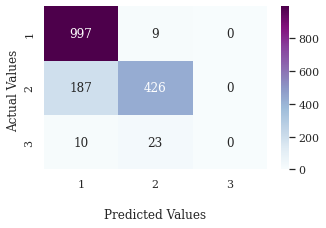

              precision    recall  f1-score   support

           1       0.84      0.99      0.91      1006
           2       0.93      0.69      0.80       613
           3       0.00      0.00      0.00        33

    accuracy                           0.86      1652
   macro avg       0.59      0.56      0.57      1652
weighted avg       0.85      0.86      0.85      1652

F1 Score: 0.8471274087446997
Recall: 0.8613801452784504
Precision: 0.8536251399137363

 Testing Data:


C:\Users\gabri\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gabri\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gabri\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

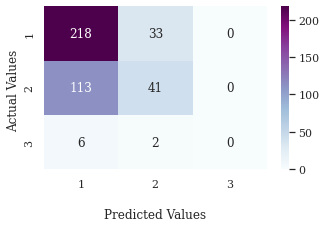

              precision    recall  f1-score   support

           1       0.65      0.87      0.74       251
           2       0.54      0.27      0.36       154
           3       0.00      0.00      0.00         8

    accuracy                           0.63       413
   macro avg       0.40      0.38      0.37       413
weighted avg       0.59      0.63      0.58       413

F1 Score: 0.583583520785933
Recall: 0.6271186440677966
Precision: 0.5943024210427996


C:\Users\gabri\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gabri\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gabri\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [43]:
testing_the_classifier(["1","2","3"])

## 3rd: Support Vector Machines

In [44]:
#PitsUnified_Finished.columns

Selected=['season','round','laps', 'driverId_enc',
       'Circuit.circuitId_enc', 'Circuit.Location.country_enc',
       'Constructor.constructorId_enc']
       
#Divide data into training and testing - stratified
from sklearn.model_selection import train_test_split #separte train and test data

X_train, X_test, y_train, y_test = train_test_split(PitsUnified_Finished[Selected], PitsUnified_Finished["Num_Pits"], test_size=0.20,stratify=PitsUnified_Finished["Num_Pits"],random_state=selectednumber)


In [45]:
# from sklearn.svm import SVC

# #Cross Validation using Grid Search
# SupVecMac=SVC(random_state=selectednumber)
# tuned_parameters = {'kernel': ["linear", "poly", "sigmoid"],
#                     "class_weight":["balanced",None],
#                     "C":np.linspace(0.1, 10, 50)}

# for x in [5,7]:
#     clf1 = GridSearchCV(SupVecMac, tuned_parameters, cv=KFold(n_splits=x), scoring=f1_scorer)
#     clf1.fit(X_train, y_train)
#     print("Folds: ",x,"- F1 Scorer: ",clf1.best_score_," ",clf1.best_params_)

# for x in [5,7]:
#     clf2 = GridSearchCV(SupVecMac, tuned_parameters, cv=KFold(n_splits=x), scoring=accuracy_scorer)
#     clf2.fit(X_train, y_train)
#     print("Folds: ",x,"- Accuracy: ",clf2.best_score_," ",clf2.best_params_)

# Folds:  5 - F1 Scorer:  0.8470408598081104   {'C': 0.1, 'class_weight': None, 'kernel': 'linear'}
# Folds:  7 - F1 Scorer:  0.8470690438082643   {'C': 0.1, 'class_weight': None, 'kernel': 'linear'}
# Folds:  5 - Accuracy:  0.8613732491073882   {'C': 0.1, 'class_weight': None, 'kernel': 'linear'}
# Folds:  7 - Accuracy:  0.8613801452784504   {'C': 0.1, 'class_weight': None, 'kernel': 'linear'}


In [46]:
# from sklearn.svm import SVC

# #Cross Validation using Grid Search
# SupVecMac=SVC(random_state=selectednumber,kernel="rbf")
# tuned_parameters = {"class_weight":["balanced",None],
#                     "gamma":["scale","auto",0.0001,0.1,1,2,3,4,5,6,7,8,9,10]}
# for x in [5,7]:
#     clf1 = GridSearchCV(SupVecMac, tuned_parameters, cv=KFold(n_splits=x), scoring=f1_scorer)
#     clf1.fit(X_train, y_train)
#     print("Folds: ",x,"- F1 Scorer: ",clf1.best_score_," ",clf1.best_params_)

# for x in [5,7]:
#     clf2 = GridSearchCV(SupVecMac, tuned_parameters, cv=KFold(n_splits=x), scoring=accuracy_scorer)
#     clf2.fit(X_train, y_train)
#     print("Folds: ",x,"- Accuracy: ",clf2.best_score_," ",clf2.best_params_)


# Folds:  5 - F1 Scorer:  0.8173106419842868   {'class_weight': None, 'gamma': 0.0001}
# Folds:  7 - F1 Scorer:  0.8178745347242534   {'class_weight': None, 'gamma': 0.0001}
# Folds:  5 - Accuracy:  0.8353437700265494   {'class_weight': None, 'gamma': 0.0001}
# Folds:  7 - Accuracy:  0.8359564164648912   {'class_weight': None, 'gamma': 0.0001}

In [47]:
from sklearn.svm import SVC
#Choosing C: Medium Chapter 2 : SVM (Support Vector Machine)
SupVecMac=SVC(kernel="rbf",random_state=selectednumber,gamma=0.1,class_weight=None)
SupVecMac.fit(X_train, y_train)
y_train_predicted=SupVecMac.predict(X_train)
y_test_predicted=SupVecMac.predict(X_test)

mse_train = mean_squared_error(y_train,y_train_predicted)
mse_test = mean_squared_error(y_test,y_test_predicted)
print(mse_train,"-",mse_test)

0.14043583535108958 - 0.44552058111380144


## 3rd: Results


 Training Data:


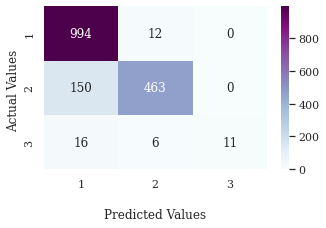

              precision    recall  f1-score   support

           1       0.86      0.99      0.92      1006
           2       0.96      0.76      0.85       613
           3       1.00      0.33      0.50        33

    accuracy                           0.89      1652
   macro avg       0.94      0.69      0.75      1652
weighted avg       0.90      0.89      0.88      1652

F1 Score: 0.8829857807526185
Recall: 0.8886198547215496
Precision: 0.8989698680961101

 Testing Data:


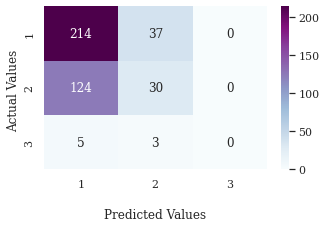

              precision    recall  f1-score   support

           1       0.62      0.85      0.72       251
           2       0.43      0.19      0.27       154
           3       0.00      0.00      0.00         8

    accuracy                           0.59       413
   macro avg       0.35      0.35      0.33       413
weighted avg       0.54      0.59      0.54       413

F1 Score: 0.5377850335477454
Recall: 0.5907990314769975
Precision: 0.538984462688569


C:\Users\gabri\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gabri\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gabri\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [48]:
testing_the_classifier(["1","2","3"])

## 4rd: Multilayer Perceptron

In [49]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import utils

classes = PitsUnified_Finished['Num_Pits'].unique().max()  # max number of laps 
optimizer = SGD(lr=0.00001) # Stochastic gradient descent optimiser



C:\Users\gabri\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\optimizer_v2\gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [50]:
#Divide data into training and testing - stratified

Selected=['season','round','laps', 'driverId_enc',
       'Circuit.circuitId_enc', 'Circuit.Location.country_enc','Constructor.constructorId_enc']

#The 3 features including the Pit laps will be taken out later

X_train, X_test, y_train, y_test = train_test_split(PitsUnified_Finished[Selected], PitsUnified_Finished['Num_Pits'], test_size=0.20,stratify=PitsUnified_Finished["Num_Pits"],random_state=selectednumber)


In [51]:
# convert class vectors to binary class matrices
y_train = utils.to_categorical(y_train, classes+1)

y_test = utils.to_categorical(y_test, classes+1)


In [52]:
model=0
history=0

In [54]:
#num of parameters is (#independtent+error)*#outputs
# import the dropout layer type
from tensorflow.keras.layers import Dropout
import tensorflow as tf

model = Sequential()

#1st hidden layer:
model.add(Dense(2, input_shape=(X_train.shape[1],))) #imput shape is the number of independent features
model.add(Activation('relu'))
model.add(Dropout(0.3))

#2nd hidden layer
model.add(Dense(3))
model.add(Activation('relu'))
model.add(Dropout(0.3))

#Output layer
model.add(Dense(classes+1))
model.add(Activation('softmax'))

# model compilation
model.summary()

# model compilation
#model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=[tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=["accuracy"])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 2)                 16        
                                                                 
 activation_2 (Activation)   (None, 2)                 0         
                                                                 
 dropout_2 (Dropout)         (None, 2)                 0         
                                                                 
 dense_3 (Dense)             (None, 3)                 9         
                                                                 
 activation_3 (Activation)   (None, 3)                 0         
                                                                 
 dropout_3 (Dropout)         (None, 3)                 0         
                                                                 
 dense_4 (Dense)             (None, 4)                

In [55]:
#train the network
history = model.fit(X_train, y_train, batch_size=32, epochs=10, verbose=1, validation_split=0.20,shuffle=True)

Epoch 1/10
42/42 [==============================] - 0s 3ms/step - loss: 1.3862 - accuracy: 0.5980 - val_loss: 1.3862 - val_accuracy: 0.5921
Epoch 2/10
42/42 [==============================] - 0s 1ms/step - loss: 1.3861 - accuracy: 0.6132 - val_loss: 1.3861 - val_accuracy: 0.5921
Epoch 3/10
42/42 [==============================] - 0s 1ms/step - loss: 1.3860 - accuracy: 0.6132 - val_loss: 1.3860 - val_accuracy: 0.5921
Epoch 4/10
42/42 [==============================] - 0s 995us/step - loss: 1.3859 - accuracy: 0.6132 - val_loss: 1.3859 - val_accuracy: 0.5921
Epoch 5/10
42/42 [==============================] - 0s 997us/step - loss: 1.3858 - accuracy: 0.6132 - val_loss: 1.3858 - val_accuracy: 0.5921
Epoch 6/10
42/42 [==============================] - 0s 1ms/step - loss: 1.3857 - accuracy: 0.6132 - val_loss: 1.3857 - val_accuracy: 0.5921
Epoch 7/10
42/42 [==============================] - 0s 1ms/step - loss: 1.3856 - accuracy: 0.6132 - val_loss: 1.3855 - val_accuracy: 0.5921
Epoch 8/10
42/42

## 4rd: Results

In [56]:
print("Final Scores:")
scoretr = model.evaluate(X_train, y_train)
scorete = model.evaluate(X_test, y_test)

print("\nTraining score/loss:", scoretr[0])
print("Training accuracy:", scoretr[1])
print("\nTest score/loss:", scorete[0])
print("Test accuracy:", scorete[1])



Final Scores:
13/13 [==============================] - 0s 665us/step - loss: 1.3852 - accuracy: 0.6077

Training score/loss: 1.385201096534729
Training accuracy: 0.6089588403701782

Test score/loss: 1.3852015733718872
Test accuracy: 0.6077482104301453


In [ ]:
predictTRAIN=model.predict(X_train)
y_train_predictedt=[]
for i in predictTRAIN:
    if i[0]==max(i):
        y_train_predictedt+=[0]
    if i[1]==max(i):
        y_train_predictedt+=[1]
    if i[2]==max(i):
        y_train_predictedt+=[2]
    if i[3]==max(i):
        y_train_predictedt+=[3]

y_train_predicted=np.array(y_train_predictedt)

predictTEST=model.predict(X_test)
y_test_predictedt=[]
for i in predictTEST:
    if i[0]==max(i):
        y_test_predictedt+=[0]
    if i[1]==max(i):
        y_test_predictedt+=[1]
    if i[2]==max(i):
        y_test_predictedt+=[2]
    if i[3]==max(i):
        y_test_predictedt+=[3]

y_test_predicted=np.array(y_test_predictedt)

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

13/13 [==============================] - 0s 664us/step - loss: 1.3852 - accuracy: 0.6077

Test score/loss: 1.3852015733718872
Test accuracy: 0.6077482104301453


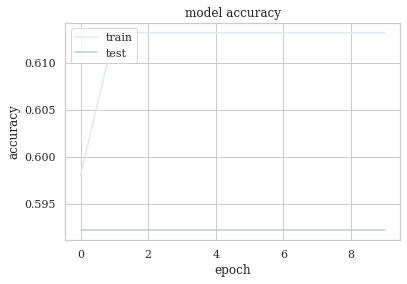

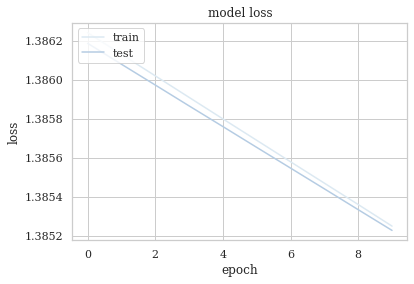

In [57]:
score = model.evaluate(X_test, y_test, verbose=1)
print("\nTest score/loss:", score[0])
print('Test accuracy:', score[1])

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Conclusion... for now...

In the 4 attempts we had, the top percentage of accuracy we got was around the 60%. It is sad to say that to be able to calculate the number of pit stops per race for each driver, we need more features available such as the tire compound, various metrics of the performance of the cars, the weather conditions, etc. Also, factors like safety cars and luck can also influence the number of pit stops and in which lap they were performed. 

In the future, when I find more data available, I would love to try this exercise all over again. 